# Checkpoint

In [6]:
import h5py
import numpy as np

In [2]:
with h5py.File('embedding.h5', 'r') as fh:
    embedding = fh['embedding'][:]

In [3]:
with h5py.File('train.h5', 'r') as fh:
    xpTrain = fh['xpTrain'][:]
    xaTrain = fh['xaTrain'][:]
    xVal = fh['xVal'][:]
    yTrain = fh['yTrain'][:]
    yVal = fh['yVal'][:]

In [4]:
with h5py.File('test.h5', 'r') as fh:
    xpTest = fh['xpTest'][:]
    xa1Test = fh['xa1Test'][:]
    xa2Test = fh['xa2Test'][:]
    yTest = fh['yTest'][:]

In [7]:
xpVal = np.vstack((xpTest, xpTest))
xaVal = xVal

# Load Model

## Set Hyperparameters

In [8]:
DELTA = 0.009
MAX_P_LEN = 13
MAX_A_LEN = 11
VOCAB_SIZE = 3371
SEED = 42
EMBEDDING_DIM = 300
TUNE = False
BATCH_SIZE = 200
NUM_EPOCHS = 1024
CNN_SIZE = 64
WINDOW_SIZE = 3
L2_NORM = 1e-4
WEIGHT_CONSTRAINT = 3.
DROPOUT_RATE = 0.2

## Import Libraries

In [9]:
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Dropout, Activation, Lambda, dot
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from keras import losses
from keras import optimizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Build Graph

In [11]:
def hinge(y_true, y_pred):
    """
    Define hinge loss function
    """
    return K.mean(K.maximum(DELTA - y_true * y_pred, 0.), axis=-1)

def build():
    """
    Build model
    """
    K.clear_session()
    inputs = Input(shape=(None,))
    emb_seq = Embedding(VOCAB_SIZE, 
                        EMBEDDING_DIM, 
                        weights=[embedding], 
                        mask_zero=False, 
                        trainable=TUNE)(inputs)
    conv = Conv1D(CNN_SIZE, 
                  WINDOW_SIZE, 
                  padding='same', 
                  activation=None,
                  kernel_regularizer=l2(L2_NORM),
                  kernel_constraint=maxnorm(WEIGHT_CONSTRAINT))(emb_seq)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    pool = GlobalMaxPooling1D()(conv)
    pool = Dropout(DROPOUT_RATE)(pool)
    outputs = Activation('tanh')(pool)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build()
p_seq, a_seq = Input(shape=(MAX_P_LEN,)), Input(shape=(MAX_A_LEN,))
p_out, a_out = model(p_seq), model(a_seq)
similarity = dot([p_out, a_out], axes=-1, normalize=True)
qa = Model(inputs=[p_seq, a_seq], outputs=[similarity])
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
qa.compile(loss=hinge, optimizer='sgd')

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         1011300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          57664     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [13]:
qa.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 13)            0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 11)            0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 64)            1069220     input_2[0][0]                    
                                                                   input_3[0][0]                    
____________________________________________________________________________________________________
dot_1 (Dot)                      (None, 1)             0           model_1[1][0]           

# Train

In [14]:
from tqdm import tqdm

In [15]:
def accuracy(p, a1, a2, actu, show=True):
    """
    Calculate Accuracy
    """
    A1 = qa.predict([p, a1])
    A2 = qa.predict([p, a2])
    pred = []
    for i in range(len(p)):
        if A1[i] > A2[i]:
            pred.append(1)
        else:
            pred.append(2)
    S = sum([1 for i in range(len(pred)) if pred[i] == actu[i]])
    ACC = S / len(actu)
    if show:
        print('Accuracy: \t%.3f' % (ACC))
    return np.array([ACC])

def plot_acc(acc, num_epochs):
    """
    Plot Accuracy
    """
    print('MAX Accuracy: \t%.3f' % (max(acc)))
    epochs = list(range(1, num_epochs+1))
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label="Accuracy", color="red", linewidth=1)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks([i for i in range(1, len(acc), len(acc)//10)])
    plt.grid(True)  
    plt.legend()
    plt.show()
    
def plot_loss(log):
    """
    Plot Loss
    """
    plt.figure(figsize=(10, 8))
    loss = log['loss']
    if 'val_loss' in log:
        val_loss = log['val_loss']
        plt.plot(val_loss, color="r", label="Val Loss")
    plt.plot(loss, color="g", label="Train Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(loc="best")
    plt.show()
    
def train(model, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=1, show=True, plot=True):
    """
    Train
    """
    ACC = []
    history = {}
    for e in range(num_epochs):
        print('EPOCHS', e+1)
        t = model.fit([xpTrain, xaTrain],
                      yTrain,
                      batch_size=batch_size,
                      epochs=1,
                      shuffle=True,
                      validation_data=([xpVal, xaVal], yVal),
                      verbose=verbose)
        for i, j in t.history.items():
            history[i] = history.get(i, []) + j
        ACC.append(accuracy(xpTest, xa1Test, xa2Test, yTest, show=show))
    if plot:
        plot_acc(ACC, num_epochs)
        plot_loss(history)
    ACC = sum([list(i) for i in ACC], [])
    K.clear_session()
    return max(ACC)

EPOCHS 1
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 1s - loss: 0.3432 - val_loss: 0.4415
Accuracy: 	0.486
EPOCHS 2
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.3229 - val_loss: 0.3977
Accuracy: 	0.478
EPOCHS 3
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.3071 - val_loss: 0.3314
Accuracy: 	0.502
EPOCHS 4
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.2907 - val_loss: 0.2630
Accuracy: 	0.458
EPOCHS 5
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.2751 - val_loss: 0.1914
Accuracy: 	0.476
EPOCHS 6
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.2638 - val_loss: 0.2313
Accuracy: 	0.472
EPOC

1000/1000 [==============================] - 0s - loss: 0.0795 - val_loss: 0.0692
Accuracy: 	0.498
EPOCHS 51
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0711 - val_loss: 0.0741
Accuracy: 	0.492
EPOCHS 52
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0710 - val_loss: 0.1188
Accuracy: 	0.470
EPOCHS 53
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0795 - val_loss: 0.0739
Accuracy: 	0.464
EPOCHS 54
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0673 - val_loss: 0.0738
Accuracy: 	0.474
EPOCHS 55
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0761 - val_loss: 0.0730
Accuracy: 	0.496
EPOCHS 56
Train on 1000 samples, validate on 1000 samples
Epoch 1/

1000/1000 [==============================] - 0s - loss: 0.0449 - val_loss: 0.1262
Accuracy: 	0.506
EPOCHS 100
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0396 - val_loss: 0.1066
Accuracy: 	0.504
EPOCHS 101
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0270 - val_loss: 0.1116
Accuracy: 	0.516
EPOCHS 102
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0337 - val_loss: 0.1231
Accuracy: 	0.532
EPOCHS 103
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0441 - val_loss: 0.1144
Accuracy: 	0.514
EPOCHS 104
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0378 - val_loss: 0.1330
Accuracy: 	0.512
EPOCHS 105
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0366 - val_loss: 0.1110
Accuracy: 	0.528
EPOCHS 149
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0216 - val_loss: 0.1370
Accuracy: 	0.512
EPOCHS 150
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0288 - val_loss: 0.1087
Accuracy: 	0.522
EPOCHS 151
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0224 - val_loss: 0.1165
Accuracy: 	0.518
EPOCHS 152
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0218 - val_loss: 0.1152
Accuracy: 	0.530
EPOCHS 153
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0176 - val_loss: 0.1128
Accuracy: 	0.532
EPOCHS 154
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0221 - val_loss: 0.1119
Accuracy: 	0.502
EPOCHS 198
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0128 - val_loss: 0.1185
Accuracy: 	0.514
EPOCHS 199
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0302 - val_loss: 0.1191
Accuracy: 	0.498
EPOCHS 200
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0275 - val_loss: 0.1133
Accuracy: 	0.512
EPOCHS 201
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0134 - val_loss: 0.1084
Accuracy: 	0.510
EPOCHS 202
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0360 - val_loss: 0.1133
Accuracy: 	0.500
EPOCHS 203
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0324 - val_loss: 0.1683
Accuracy: 	0.476
EPOCHS 247
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0259 - val_loss: 0.1070
Accuracy: 	0.524
EPOCHS 248
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0069 - val_loss: 0.1028
Accuracy: 	0.512
EPOCHS 249
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0053 - val_loss: 0.1026
Accuracy: 	0.518
EPOCHS 250
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0052 - val_loss: 0.1040
Accuracy: 	0.508
EPOCHS 251
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0169 - val_loss: 0.1473
Accuracy: 	0.490
EPOCHS 252
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0222 - val_loss: 0.1155
Accuracy: 	0.522
EPOCHS 296
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0106 - val_loss: 0.1078
Accuracy: 	0.500
EPOCHS 297
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0049 - val_loss: 0.1067
Accuracy: 	0.510
EPOCHS 298
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0048 - val_loss: 0.1070
Accuracy: 	0.510
EPOCHS 299
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0048 - val_loss: 0.1056
Accuracy: 	0.502
EPOCHS 300
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0048 - val_loss: 0.1055
Accuracy: 	0.512
EPOCHS 301
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1056
Accuracy: 	0.520
EPOCHS 345
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0048 - val_loss: 0.1056
Accuracy: 	0.518
EPOCHS 346
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - ETA: 0s - loss: 0.005 - 0s - loss: 0.0047 - val_loss: 0.1054
Accuracy: 	0.518
EPOCHS 347
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0048 - val_loss: 0.1053
Accuracy: 	0.518
EPOCHS 348
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1053
Accuracy: 	0.516
EPOCHS 349
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0048 - val_loss: 0.1052
Accuracy: 	0.520
EPOCHS 350
Train on 1000 samples, val

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1056
Accuracy: 	0.522
EPOCHS 394
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1057
Accuracy: 	0.524
EPOCHS 395
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1057
Accuracy: 	0.520
EPOCHS 396
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1058
Accuracy: 	0.524
EPOCHS 397
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1058
Accuracy: 	0.524
EPOCHS 398
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1060
Accuracy: 	0.522
EPOCHS 399
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1061
Accuracy: 	0.526
EPOCHS 443
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1061
Accuracy: 	0.522
EPOCHS 444
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1061
Accuracy: 	0.524
EPOCHS 445
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1061
Accuracy: 	0.524
EPOCHS 446
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1059
Accuracy: 	0.520
EPOCHS 447
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1060
Accuracy: 	0.522
EPOCHS 448
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0046 - val_loss: 0.1057
Accuracy: 	0.508
EPOCHS 492
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1059
Accuracy: 	0.510
EPOCHS 493
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1059
Accuracy: 	0.510
EPOCHS 494
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1058
Accuracy: 	0.508
EPOCHS 495
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1057
Accuracy: 	0.512
EPOCHS 496
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1056
Accuracy: 	0.510
EPOCHS 497
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1058
Accuracy: 	0.514
EPOCHS 541
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1058
Accuracy: 	0.514
EPOCHS 542
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1058
Accuracy: 	0.516
EPOCHS 543
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1057
Accuracy: 	0.514
EPOCHS 544
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1057
Accuracy: 	0.512
EPOCHS 545
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1056
Accuracy: 	0.512
EPOCHS 546
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1065
Accuracy: 	0.516
EPOCHS 590
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1066
Accuracy: 	0.516
EPOCHS 591
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1068
Accuracy: 	0.518
EPOCHS 592
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1070
Accuracy: 	0.520
EPOCHS 593
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1069
Accuracy: 	0.522
EPOCHS 594
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1069
Accuracy: 	0.522
EPOCHS 595
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1069
Accuracy: 	0.526
EPOCHS 639
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1070
Accuracy: 	0.526
EPOCHS 640
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1071
Accuracy: 	0.526
EPOCHS 641
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1071
Accuracy: 	0.528
EPOCHS 642
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.526
EPOCHS 643
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1070
Accuracy: 	0.526
EPOCHS 644
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.518
EPOCHS 688
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1071
Accuracy: 	0.524
EPOCHS 689
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.524
EPOCHS 690
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.524
EPOCHS 691
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.522
EPOCHS 692
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1074
Accuracy: 	0.522
EPOCHS 693
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1076
Accuracy: 	0.524
EPOCHS 737
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1076
Accuracy: 	0.524
EPOCHS 738
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1076
Accuracy: 	0.524
EPOCHS 739
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1076
Accuracy: 	0.528
EPOCHS 740
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1076
Accuracy: 	0.526
EPOCHS 741
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0046 - val_loss: 0.1075
Accuracy: 	0.528
EPOCHS 742
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1076
Accuracy: 	0.528
EPOCHS 786
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1078
Accuracy: 	0.526
EPOCHS 787
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.528
EPOCHS 788
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.526
EPOCHS 789
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.522
EPOCHS 790
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1075
Accuracy: 	0.522
EPOCHS 791
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1074
Accuracy: 	0.524
EPOCHS 835
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1074
Accuracy: 	0.524
EPOCHS 836
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1074
Accuracy: 	0.524
EPOCHS 837
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1075
Accuracy: 	0.522
EPOCHS 838
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1075
Accuracy: 	0.522
EPOCHS 839
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1075
Accuracy: 	0.520
EPOCHS 840
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.512
EPOCHS 884
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.512
EPOCHS 885
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.512
EPOCHS 886
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1071
Accuracy: 	0.514
EPOCHS 887
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.514
EPOCHS 888
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0046 - val_loss: 0.1073
Accuracy: 	0.518
EPOCHS 889
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1074
Accuracy: 	0.518
EPOCHS 933
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.520
EPOCHS 934
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1072
Accuracy: 	0.518
EPOCHS 935
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.522
EPOCHS 936
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.522
EPOCHS 937
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1073
Accuracy: 	0.522
EPOCHS 938
Train on 1000 samples, validate on 1000 samples
Ep

1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1067
Accuracy: 	0.518
EPOCHS 982
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1069
Accuracy: 	0.518
EPOCHS 983
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1069
Accuracy: 	0.520
EPOCHS 984
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0046 - val_loss: 0.1067
Accuracy: 	0.516
EPOCHS 985
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1067
Accuracy: 	0.516
EPOCHS 986
Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s - loss: 0.0047 - val_loss: 0.1068
Accuracy: 	0.516
EPOCHS 987
Train on 1000 samples, validate on 1000 samples
Ep

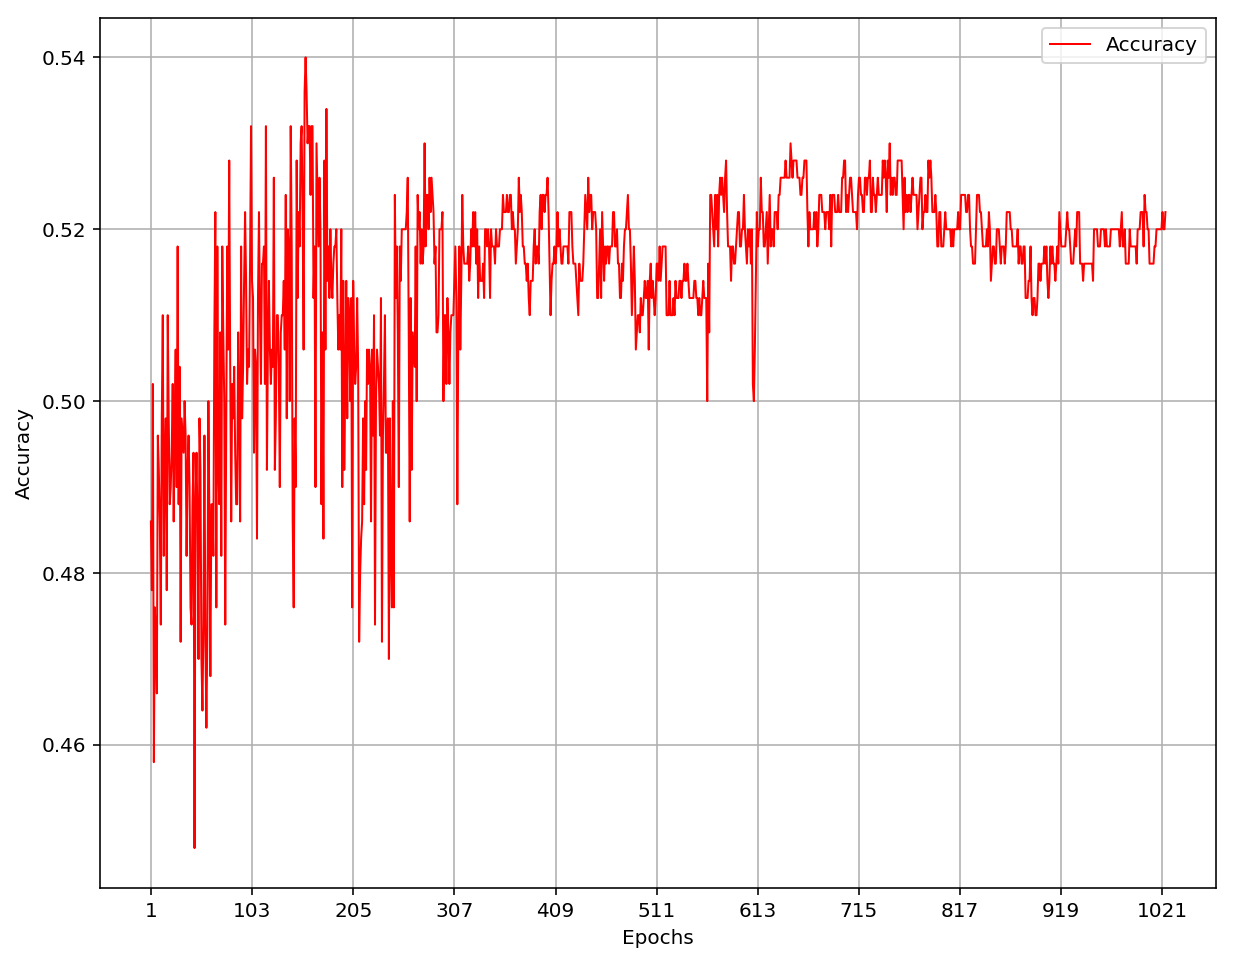

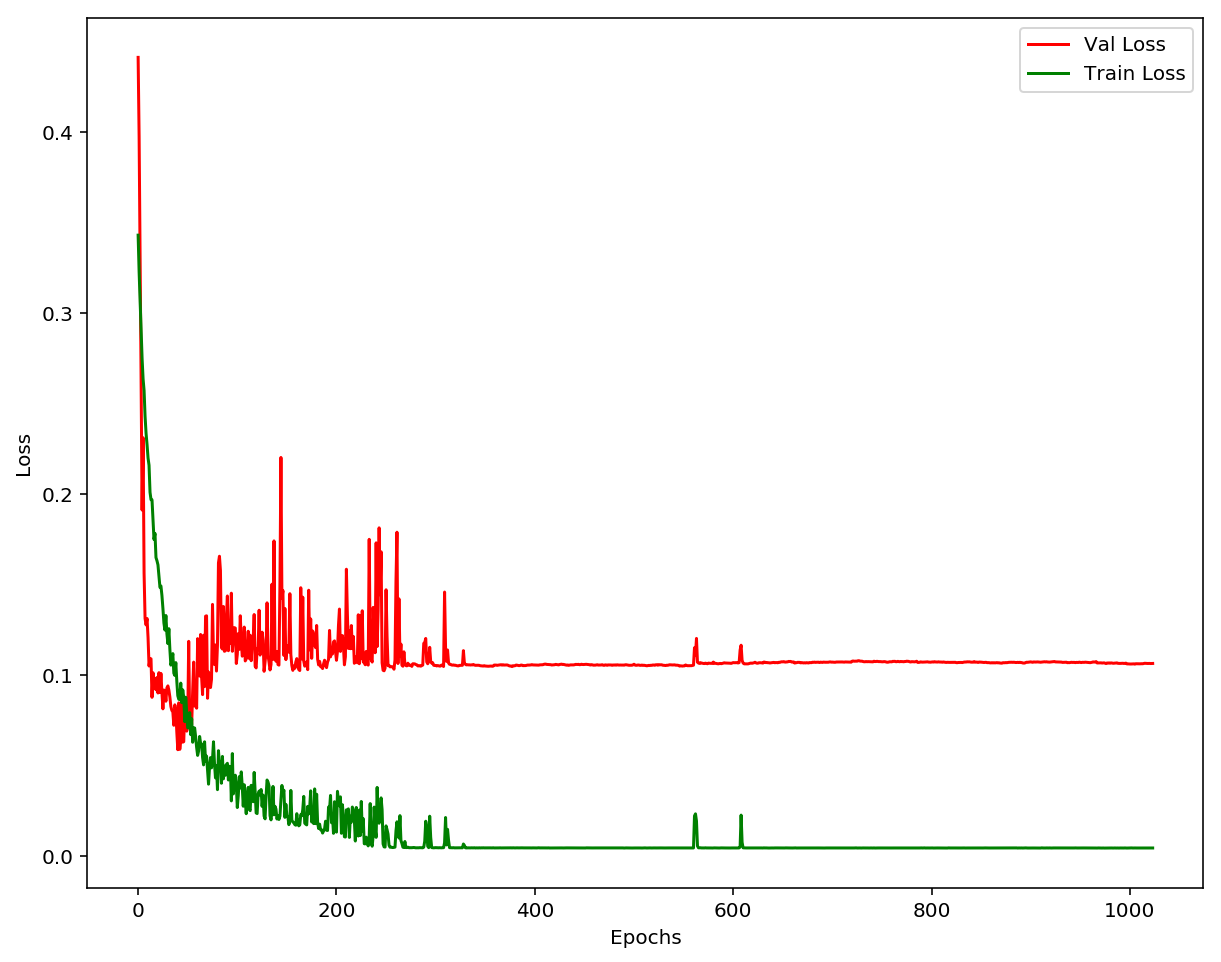

0.54000000000000004

In [16]:
train(qa)